In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import statistics

%matplotlib inline


# read file in and filter dataframe
file_path = 'hcmst2017to2022.csv'
df = pd.read_csv(file_path)

for column in df.columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')

columns_to_print_section = ['caseid_new', 'w1_section', 'w2_section', 'w3_section', 'w3_partner_source']
print("Number of records in dataset:", df[columns_to_print_section].shape)

Number of records in dataset: (3510, 5)


In [3]:
# all the people that were in one relationship throughout all w1->w3
con_w1_partnered = df['w1_section'] == 1 # those who were partenered in 2017
con_w2_married_same = df['w2_section'] == 1 # who are still married to the same partner in wave 2
con_w2_part_same = df['w2_section'] == 3 # or still partnered with that same partner but not married (but still together) in wave 2 
# (note that we are not looking at those with new partners in w2/w3)
con_w3_married_same = df['w3_section'] == 1 # who are still married to the same partner in wave 3
con_w3_partnered_same = df['w3_section'] == 3 # or still partnered with that same partner but not married (but still together) in wave 2 
con_w3_same_part_fromw1 = df['w3_partner_source'] == 1

com_con_same_rel_all_waves = con_w1_partnered & (con_w2_married_same | con_w2_part_same) & ((con_w3_married_same | con_w3_partnered_same) & con_w3_same_part_fromw1)
same_rel_all_waves_df = df.loc[com_con_same_rel_all_waves]
print(len(same_rel_all_waves_df))

1096


In [4]:
# now creating dict 3 for those who had same rel w1->w3
rel_counter = 0
dict_same_rel = {}

df_dict_same_rel = same_rel_all_waves_df.to_dict(orient='records')

for record in df_dict_same_rel:
    dict_same_rel[rel_counter] = {
        'caseid_new': record['caseid_new'], #resp case id
        'w1_ppage': record['w1_ppage'], #age
        'w1_q9': record['w1_q9'], #partner's age in 2017

        'w1_subject_race': record['w1_subject_race'], #resp race
        'w1_q6b': record['w1_q6b'], #partner's race
                
        'w1_ppeduc': record['w1_ppeduc'], #resp educ level
        'w1_q10': record['w1_q10'], #partner educ level

        'w1_partyid7':record['w1_partyid7'],
        'w1_q12':record['w1_q12'],
        'political_steps': np.abs(record['w1_partyid7']-record['w1_q12']),
            }
    rel_counter += 1

In [5]:
partner_info = {}
rec_counter = 1096

for record in df_dict_same_rel:
    partner_info [rec_counter] = {
        "r_caseid":record["caseid_new"],
        "r_gender": record["w1_ppgender"], # resp gender
        "p_gender": record["w1_q4"], # partner's gender
        
        "r_race": record["w1_ppethm"], # resp race
        "p_race": record["w1_q6b"], #partner's race
        
        "r_age": record["w1_ppage"], # resp age
        "p_age": record["w1_q9"], #partner age in 2017,
        
        "r_edu": record["w1_ppeduc"], # resp education
        "p_edu": record["w1_q10"], # partner education
        
        "r_politic": record["w1_partyid7"], # resp political affiliation
        "p_politic": record["w1_q12"] # partner political affiliation
        
    }
    rec_counter +=1
    
print("partner_info dict format:", partner_info[1096])

partner_info dict format: {'r_caseid': 71609, 'r_gender': 2, 'p_gender': 1.0, 'r_race': 1, 'p_race': 1.0, 'r_age': 68, 'p_age': 71.0, 'r_edu': 10, 'p_edu': 10.0, 'r_politic': 3.0, 'p_politic': 3.0}


In [6]:
# split couples into individual people and their attributes
all_people_id = set()
all_people = {}


for record in partner_info:
    id_1 = partner_info[record]["r_caseid"]
    id_2 = record

    all_people_id.add(id_1)
    all_people_id.add(id_2)

    all_people[id_1] = {
        "race": partner_info[record]["r_race"],
        "age": partner_info[record]["r_age"],
        "edu": partner_info[record]["r_edu"],
        "pol": partner_info[record]["r_politic"]
    }

    all_people[id_2] = {
        "race": partner_info[record]["p_race"],
        "age": partner_info[record]["p_age"],
        "edu": partner_info[record]["p_edu"],
        "pol": partner_info[record]["p_politic"]
    }

print("Number of Individual People: ", len(all_people))

Number of Individual People:  2192


In [7]:
# scoring algo from original algorithm
def cal_pol_steps(a,b):
    if (a>=1 and b>=1):
        pol_score= np.abs(np.abs(int(a)-int(b))-6)
        return round((pol_score/6)*4,3)
    else:
        return 0

def check_eth_same(a,b):
    same_eth=0
    if (a>=1 and b>=1):
        if (a==b):
            same_eth=1
            return round((same_eth/1)*3,3)
    return same_eth

def cal_age_diff(r_age,p_age):
    score_age=0
    if (r_age>=1 and p_age>=1):
        age_diff = np.abs(r_age-p_age)
        if (age_diff>=2 and age_diff<=5):
            score_age=1
            return round((score_age/1)*2,3)
    return score_age
    
def check_p_ed_greater(r_edu,p_edu):
    if (r_edu>=1 and p_edu>=1):    
        score_edu = np.abs(np.abs(r_edu-p_edu)-13)
        return round((score_edu/13)*1,3)
    else:
        return 0

In [8]:
# need to export in format that Python matching library can use
# link: https://pypi.org/project/matching/
# link 2: https://daffidwilde.github.io/matching/docs/reference/stable_roommates.html

# need: for each person x, a list that has every other person y in the group in order of person x's preference of dating them
# preference = score calculated with functions above ^
# for each person, will calculate a score for every other person (n^2) and make a sorted list

all_people_pref_scores = {}
all_people2 = all_people

i1 =0
i2=0

for record in all_people:
    id_1 = record
    score_pid = {}
    for record2 in all_people2:
        id_2 = record2
        p_score = cal_pol_steps(all_people[id_1]["pol"], all_people[id_2]["pol"])
        r_score = check_eth_same(all_people[id_1]["race"], all_people[id_2]["race"])
        a_score = cal_age_diff(all_people[id_1]["age"], all_people[id_2]["age"])
        e_score = check_p_ed_greater(all_people[id_1]["edu"], all_people[id_2]["edu"])
        score = p_score + r_score + a_score + e_score
        score_pid[id_2] = score
            
    score_pid_sorted = dict(sorted(score_pid.items(), key=lambda item: item[1], reverse=True))
    #print(score_pid)
    all_people_pref_scores[record] = score_pid_sorted
            
            

In [9]:
keys_score = list(all_people_pref_scores.keys())

In [10]:
print(all_people_pref_scores[71609])
print(len(all_people_pref_scores[71609]))

{1096: 10.0, 1155: 10.0, 1140491: 10.0, 1786749: 10.0, 1446: 10.0, 1468: 10.0, 1488: 10.0, 1497: 10.0, 1975919: 10.0, 2485815: 10.0, 2679531: 10.0, 2724951: 10.0, 2006: 10.0, 2882059: 10.0, 2145: 10.0, 214227: 9.923, 1103: 9.923, 1125: 9.923, 1180: 9.923, 1192: 9.923, 1304: 9.923, 1550311: 9.923, 1633263: 9.923, 1380: 9.923, 1925505: 9.923, 1569: 9.923, 2092107: 9.923, 1683: 9.923, 2311713: 9.923, 1813: 9.923, 1839: 9.923, 2449593: 9.923, 2493475: 9.923, 1895: 9.923, 1897: 9.923, 1956: 9.923, 1970: 9.923, 1975: 9.923, 2015: 9.923, 2035: 9.923, 2846681: 9.923, 981251: 9.846, 1348: 9.846, 1768829: 9.846, 2136629: 9.846, 1758: 9.846, 1886: 9.846, 2714381: 9.846, 2763005: 9.846, 2138: 9.846, 2166: 9.846, 1049013: 9.769, 1214: 9.769, 1966321: 9.769, 2854889: 9.769, 2914073: 9.769, 1826: 9.692, 1119: 9.333, 1333997: 9.333, 1288: 9.333, 1374661: 9.333, 1445543: 9.333, 1487: 9.333, 1910803: 9.333, 1550: 9.333, 1557: 9.333, 1749: 9.333, 1846: 9.333, 2591515: 9.333, 1991: 9.333, 2038: 9.333, 207

In [11]:
# need to remove the score for self (each person should only have 2191)
for record in all_people_pref_scores:
    preferences = all_people_pref_scores[record]
    to_remove = []
    for record2 in preferences:
        if record == record2:
            #print("R1:", record)
            #print("R2:", record2)
            preferences.pop(record2, None)
            break

        

In [12]:
print(len(all_people_pref_scores[1096]))

2191


In [13]:
print("Format of all_pref_scores..... key = 71609 : ", all_people_pref_scores[71609])

Format of all_pref_scores..... key = 71609 :  {1096: 10.0, 1155: 10.0, 1140491: 10.0, 1786749: 10.0, 1446: 10.0, 1468: 10.0, 1488: 10.0, 1497: 10.0, 1975919: 10.0, 2485815: 10.0, 2679531: 10.0, 2724951: 10.0, 2006: 10.0, 2882059: 10.0, 2145: 10.0, 214227: 9.923, 1103: 9.923, 1125: 9.923, 1180: 9.923, 1192: 9.923, 1304: 9.923, 1550311: 9.923, 1633263: 9.923, 1380: 9.923, 1925505: 9.923, 1569: 9.923, 2092107: 9.923, 1683: 9.923, 2311713: 9.923, 1813: 9.923, 1839: 9.923, 2449593: 9.923, 2493475: 9.923, 1895: 9.923, 1897: 9.923, 1956: 9.923, 1970: 9.923, 1975: 9.923, 2015: 9.923, 2035: 9.923, 2846681: 9.923, 981251: 9.846, 1348: 9.846, 1768829: 9.846, 2136629: 9.846, 1758: 9.846, 1886: 9.846, 2714381: 9.846, 2763005: 9.846, 2138: 9.846, 2166: 9.846, 1049013: 9.769, 1214: 9.769, 1966321: 9.769, 2854889: 9.769, 2914073: 9.769, 1826: 9.692, 1119: 9.333, 1333997: 9.333, 1288: 9.333, 1374661: 9.333, 1445543: 9.333, 1487: 9.333, 1910803: 9.333, 1550: 9.333, 1557: 9.333, 1749: 9.333, 1846: 9.333,

In [14]:
num_partners_abv_avg_dict = {}

# count how many people > avg score of original relationships
for record in all_people_pref_scores:
    pot_part = all_people_pref_scores[record]

    num_pot_partners = 0

    for partner in pot_part:
        score = pot_part[partner]
        if(score > 7.6):
            num_pot_partners += 1

    num_partners_abv_avg_dict[record] = num_pot_partners
            

In [17]:
sorted_num_partners_abv_avg_dict =dict(sorted(num_partners_abv_avg_dict.items(), key=lambda item: item[1], reverse=True))
print(sorted_num_partners_abv_avg_dict)

{1179591: 599, 1344091: 599, 1316: 599, 1362: 599, 1976605: 599, 2408297: 599, 1923: 599, 1215: 598, 1913143: 598, 2757001: 598, 2786595: 598, 1196: 597, 1763355: 597, 2207753: 596, 2478637: 596, 1376: 595, 1731569: 595, 2039: 595, 2900187: 595, 1672: 594, 1276181: 593, 1682591: 593, 1901639: 593, 1520: 593, 2014793: 593, 1596: 593, 1742: 593, 1765: 593, 1873: 593, 2840173: 593, 2129: 593, 1163: 592, 1740471: 592, 2507307: 592, 1245: 591, 1407429: 591, 1784: 591, 1337: 590, 1593839: 590, 1638615: 590, 2452097: 590, 2094: 590, 646157: 588, 1251293: 588, 1412: 588, 1431: 588, 1365: 583, 1908: 583, 2060: 583, 1433: 582, 1336987: 581, 1137: 580, 1266: 580, 1792531: 580, 1934: 580, 1937: 580, 1960: 580, 657869: 579, 817367: 579, 1477: 579, 1486: 579, 1514: 579, 1574: 579, 1599: 579, 1712857: 578, 1126: 577, 1244: 577, 1294: 577, 2022: 577, 2159: 577, 1325: 576, 1572635: 576, 1891491: 576, 1571: 576, 1649: 576, 2174237: 576, 1806: 576, 1967: 576, 2898559: 576, 1073943: 575, 1377765: 575, 163

In [19]:
grouped_dict = {
        '0-50': [],
        '51-100': [],
        '101-150': [],
        '151-200': [],
        '201-250': [],
        '251-300': [],
        '301-350': [],
        '351-400': [],
        '401-450': [],
        '451-500': [],
        '501-550': [],
        '551-600': []
    }

for key, value in sorted_num_partners_abv_avg_dict.items():
    if 0 <= value <= 50:
        grouped_dict['0-50'].append((key, value))
    elif 51 <= value <= 100:
        grouped_dict['51-100'].append((key, value))
    elif 101 <= value <= 150:
        grouped_dict['101-150'].append((key, value))
    elif 151 <= value <= 200:
        grouped_dict['151-200'].append((key, value))
    elif 201 <= value <= 250:
        grouped_dict['201-250'].append((key, value))
    elif 251 <= value <= 300:
        grouped_dict['251-300'].append((key, value))
    elif 301 <= value <= 350:
        grouped_dict['301-350'].append((key, value))
    elif 351 <= value <= 400:
        grouped_dict['351-400'].append((key, value))
    elif 401 <= value <= 450:
        grouped_dict['401-450'].append((key, value))
    elif 451 <= value <= 500:
        grouped_dict['451-500'].append((key, value))
    elif 501 <= value <= 550:
        grouped_dict['501-550'].append((key, value))
    elif 551 <= value <= 600:
        grouped_dict['551-600'].append((key, value))

In [23]:
count_range = {}

for record in grouped_dict:
    count_range[record] = len(grouped_dict[record])
    #print(record, ":", len(grouped_dict[record]))

In [24]:
print(count_range)

{'0-50': 366, '51-100': 50, '101-150': 3, '151-200': 4, '201-250': 37, '251-300': 78, '301-350': 190, '351-400': 407, '401-450': 456, '451-500': 293, '501-550': 188, '551-600': 120}


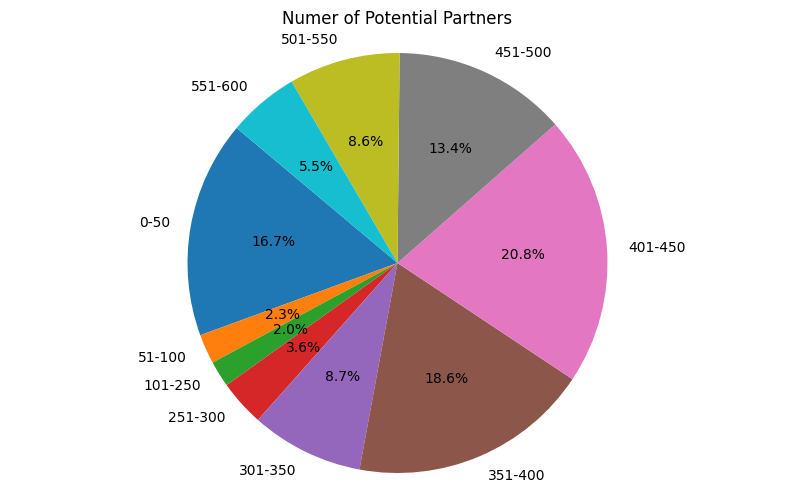

In [29]:
count_range2 = {'0-50': 366, '51-100': 50, '101-250': 44, '251-300': 78, '301-350': 190, '351-400': 407, '401-450': 456, '451-500': 293, '501-550': 188, '551-600': 120}
labels = count_range2.keys()
sizes = count_range2.values()

plt.figure(figsize=(10, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Numer of Potential Partners')
plt.show()


In [32]:
appearance_in_others_pp_dict = {}

for person in list(all_people_pref_scores.keys()):
    count_p = person
    count_app = 0
    
    for record in all_people_pref_scores: # for each person
        if person != record: # other than themselves
            pot_part = all_people_pref_scores[record]
            for partner in pot_part: # if they appear in list
                if (partner == count_p) and (pot_part[partner]>7.6):# add to count
                    print(count_p)
                    print(partner)
                    count_app += 1
                    
    appearance_in_others_pp_dict[person] = count_app

print(appearance_in_others_pp_dict)
            

{71609: 479, 1096: 439, 106983: 365, 1097: 418, 164061: 445, 1098: 411, 212249: 12, 1099: 12, 214227: 436, 1100: 22, 218351: 341, 1101: 341, 220655: 13, 1102: 12, 291177: 448, 1103: 552, 369975: 56, 1104: 55, 428211: 18, 1105: 40, 497203: 445, 1106: 423, 516823: 239, 1107: 357, 582849: 426, 1108: 400, 587125: 351, 1109: 529, 589881: 476, 1110: 478, 608697: 422, 1111: 423, 621641: 378, 1112: 447, 632253: 372, 1113: 41, 634833: 416, 1114: 438, 637531: 281, 1115: 17, 643423: 504, 1116: 393, 643505: 20, 1117: 504, 646023: 482, 1118: 431, 646157: 588, 1119: 546, 648669: 426, 1120: 402, 650237: 22, 1121: 446, 651259: 390, 1122: 495, 651349: 416, 1123: 439, 653633: 473, 1124: 428, 654589: 15, 1125: 531, 657869: 579, 1126: 577, 662355: 354, 1127: 549, 694739: 500, 1128: 512, 698117: 306, 1129: 396, 703017: 443, 1130: 446, 704661: 271, 1131: 351, 705457: 339, 1132: 356, 709075: 483, 1133: 281, 709173: 39, 1134: 434, 724199: 9, 1135: 339, 726183: 537, 1136: 386, 726431: 523, 1137: 580, 727775: 3

In [33]:
sorted_appearance_in_others_pp_dict = dict(sorted(appearance_in_others_pp_dict.items(), key=lambda item: item[1], reverse=True))
print(sorted_appearance_in_others_pp_dict)

{1179591: 599, 1344091: 599, 1316: 599, 1362: 599, 1976605: 599, 2408297: 599, 1923: 599, 1215: 598, 1913143: 598, 2757001: 598, 2786595: 598, 1196: 597, 1763355: 597, 2207753: 596, 2478637: 596, 1376: 595, 1731569: 595, 2039: 595, 2900187: 595, 1672: 594, 1276181: 593, 1682591: 593, 1901639: 593, 1520: 593, 2014793: 593, 1596: 593, 1742: 593, 1765: 593, 1873: 593, 2840173: 593, 2129: 593, 1163: 592, 1740471: 592, 2507307: 592, 1245: 591, 1407429: 591, 1784: 591, 1337: 590, 1593839: 590, 1638615: 590, 2452097: 590, 2094: 590, 646157: 588, 1251293: 588, 1412: 588, 1431: 588, 1365: 583, 1908: 583, 2060: 583, 1433: 582, 1336987: 581, 1137: 580, 1266: 580, 1792531: 580, 1934: 580, 1937: 580, 1960: 580, 657869: 579, 817367: 579, 1477: 579, 1486: 579, 1514: 579, 1574: 579, 1599: 579, 1712857: 578, 1126: 577, 1244: 577, 1294: 577, 2022: 577, 2159: 577, 1325: 576, 1572635: 576, 1891491: 576, 1571: 576, 1649: 576, 2174237: 576, 1806: 576, 1967: 576, 2898559: 576, 1073943: 575, 1377765: 575, 163

In [34]:
grouped_dict = {
        '0-50': [],
        '51-100': [],
        '101-150': [],
        '151-200': [],
        '201-250': [],
        '251-300': [],
        '301-350': [],
        '351-400': [],
        '401-450': [],
        '451-500': [],
        '501-550': [],
        '551-600': []
    }

for key, value in sorted_appearance_in_others_pp_dict.items():
    if 0 <= value <= 50:
        grouped_dict['0-50'].append((key, value))
    elif 51 <= value <= 100:
        grouped_dict['51-100'].append((key, value))
    elif 101 <= value <= 150:
        grouped_dict['101-150'].append((key, value))
    elif 151 <= value <= 200:
        grouped_dict['151-200'].append((key, value))
    elif 201 <= value <= 250:
        grouped_dict['201-250'].append((key, value))
    elif 251 <= value <= 300:
        grouped_dict['251-300'].append((key, value))
    elif 301 <= value <= 350:
        grouped_dict['301-350'].append((key, value))
    elif 351 <= value <= 400:
        grouped_dict['351-400'].append((key, value))
    elif 401 <= value <= 450:
        grouped_dict['401-450'].append((key, value))
    elif 451 <= value <= 500:
        grouped_dict['451-500'].append((key, value))
    elif 501 <= value <= 550:
        grouped_dict['501-550'].append((key, value))
    elif 551 <= value <= 600:
        grouped_dict['551-600'].append((key, value))

In [35]:
count_range = {}

for record in grouped_dict:
    count_range[record] = len(grouped_dict[record])
    #print(record, ":", len(grouped_dict[record]))

print(count_range)

{'0-50': 366, '51-100': 50, '101-150': 3, '151-200': 4, '201-250': 37, '251-300': 78, '301-350': 190, '351-400': 407, '401-450': 456, '451-500': 293, '501-550': 188, '551-600': 120}


In [ ]:
## those that appear the most = the same = most potential matches

In [ ]:
grouped_dict = {
        '0-50': [],
        '51-100': [],
        '101-150': [],
        '151-200': [],
        '201-250': [],
        '251-300': [],
        '301-350': [],
        '351-400': [],
        '401-450': [],
        '451-500': [],
        '501-550': [],
        '551-600': []
    }

for key, value in sorted_num_partners_abv_avg_dict.items():
    if 0 <= value <= 50:
        grouped_dict['0-50'].append((key, value))
    elif 51 <= value <= 100:
        grouped_dict['51-100'].append((key, value))
    elif 101 <= value <= 150:
        grouped_dict['101-150'].append((key, value))
    elif 151 <= value <= 200:
        grouped_dict['151-200'].append((key, value))
    elif 201 <= value <= 250:
        grouped_dict['201-250'].append((key, value))
    elif 251 <= value <= 300:
        grouped_dict['251-300'].append((key, value))
    elif 301 <= value <= 350:
        grouped_dict['301-350'].append((key, value))
    elif 351 <= value <= 400:
        grouped_dict['351-400'].append((key, value))
    elif 401 <= value <= 450:
        grouped_dict['401-450'].append((key, value))
    elif 451 <= value <= 500:
        grouped_dict['451-500'].append((key, value))
    elif 501 <= value <= 550:
        grouped_dict['501-550'].append((key, value))
    elif 551 <= value <= 600:
        grouped_dict['551-600'].append((key, value))
        

In [70]:
#print(grouped_dict['551-600'])
highestPotPart = grouped_dict['551-600']
print(len(highestPotPart))

high_dict = {
    "pol": [],
    "age": [],
    "edu": [],
    "race": []
}

for person in highestPotPart:
    person_id = person[0]
    for attr in list(high_dict.keys()):
        high_dict[attr].append( all_people[person_id][attr])

120


In [78]:
#print(high_dict)
print("High PP Pol Median:", np.median(high_dict["pol"]))
print("High PP Age Median:", np.median(high_dict["age"]))
print("High PP Edu Median:", np.median(high_dict["edu"]))
print("High PP RE Mode:", statistics.mode(high_dict["race"]))



High PP Pol Median: 3.0
High PP Age Median: 57.0
High PP Edu Median: 10.0
High PP RE Mode: 1


In [79]:
## now other side of the coin
lowestPotPart = grouped_dict['0-50']
print(len(lowestPotPart))

low_dict = {
    "pol": [],
    "age": [],
    "edu": [],
    "race": []
}

for person in lowestPotPart:
    person_id = person[0]
    for attr in list(low_dict.keys()):
        low_dict[attr].append(all_people[person_id][attr])
        
#print(low_dict)

366


In [90]:
print("Low PP Pol Median:", np.median(low_dict["pol"]))
print("Low PP Age Median:", np.median(low_dict["age"]))
print("Low PP Edu Median:", np.median(low_dict["edu"]))
print("Low PP RE Mode:", statistics.mode(low_dict["race"]))

Low PP Pol Median: 5.0
Low PP Age Median: 47.0
Low PP Edu Median: 10.0
Low PP RE Mode: 4.0


In [91]:
print(low_dict["race"])

[2.0, 2, 4.0, 4, 2, 4.0, 2, 4, 4.0, 4, 4, 4.0, 4.0, 2.0, 1.0, 4.0, 4.0, 2, 4.0, 4.0, 2, 4.0, 4, 4, 4, 4, 4.0, 4.0, 4.0, 4.0, 4, 4, 4.0, 4, 4, 4, 4, 4, 4.0, 4.0, 4, 2.0, 2.0, 4, 4, 4, 2, 4.0, 2, 4, 4.0, 4.0, 4, 4, 4, 2.0, 4, 4.0, 4.0, 4.0, 2, 2, 2.0, 2.0, 4.0, 4, 4, 4, 4, 4, 2, 4.0, 4.0, 4, 2.0, 4, 2, 4, 4, 4.0, 2.0, 4, 2.0, 4.0, 2.0, 4, 4, 4, 2.0, 4, 2.0, 4, 4.0, 4, 4, 4, 2.0, 2, 4.0, 4, 4, 4, 4, 4.0, 2, 4, 2.0, 4, 2.0, 4, 4.0, 2.0, 4, 4, 4, 4.0, 4, 4.0, 4, 2, 2.0, 4, 4.0, 4, 4.0, 2.0, 2, 4, 4, 4.0, 4, 2, 2.0, 4, 2.0, 2, 2, 4.0, 2.0, 2, 4, 2, 4, 4.0, 2, 2.0, 4.0, 2.0, 4, 4, 2.0, 4, 4.0, 4, 2.0, 2.0, 5.0, 2.0, 5.0, 2.0, 2.0, 4, 5.0, 4, 2.0, 4, 2, 4, 5.0, 2, 2.0, 4, 4, 2.0, 4, 5.0, 2.0, 2.0, 4, 4, 4, 5.0, 4, 4, 4, 5.0, 4, 4, 4, 5.0, 4, 5.0, 2, 2.0, 5.0, 4, 4, 4, 4, 2.0, 4, 5.0, 4, 5.0, 5.0, 4, 4, 4, 4.0, 5, 2, 2.0, 4, 5.0, 5, 4, 5.0, 5.0, 5.0, 5, 5.0, 2.0, 5, 5.0, 4, 5.0, 5, 5, 5, 3.0, 5.0, 3.0, 5.0, 5.0, 5, 4, 5.0, 5, 5.0, 2.0, 3, 2, 5.0, 5, 2.0, 3, 5, 5, 5.0, 4.0, 4.0, 5.0, 5, 5.0, 3, 

In [92]:
pot_part_arr = list(num_partners_abv_avg_dict.values())
print(np.median(pot_part_arr))

397.0


In [93]:
## now other side of the coin
lowestPotPart = []

for record in grouped_dict:
    if record == "301-350":
        break
    for thing in grouped_dict[record]:
        lowestPotPart.append(thing[0])

#print(lowestPotPart)

In [94]:

low_dict = {
    "pol": [],
    "age": [],
    "edu": [],
    "race": []
}

for person in lowestPotPart:
    person_id = person
    for attr in list(low_dict.keys()):
        low_dict[attr].append(all_people[person_id][attr])

print("Low Half PP Pol Median:", np.median(low_dict["pol"]))
print("Low Half PP Age Median:", np.median(low_dict["age"]))
print("Low Half PP Edu Median:", np.median(low_dict["edu"]))
print("Low Half PP RE Mode:", statistics.mode(low_dict["race"]))

Low Half PP Pol Median: 5.0
Low Half PP Age Median: 47.0
Low Half PP Edu Median: 10.0
Low Half PP RE Mode: 4.0
